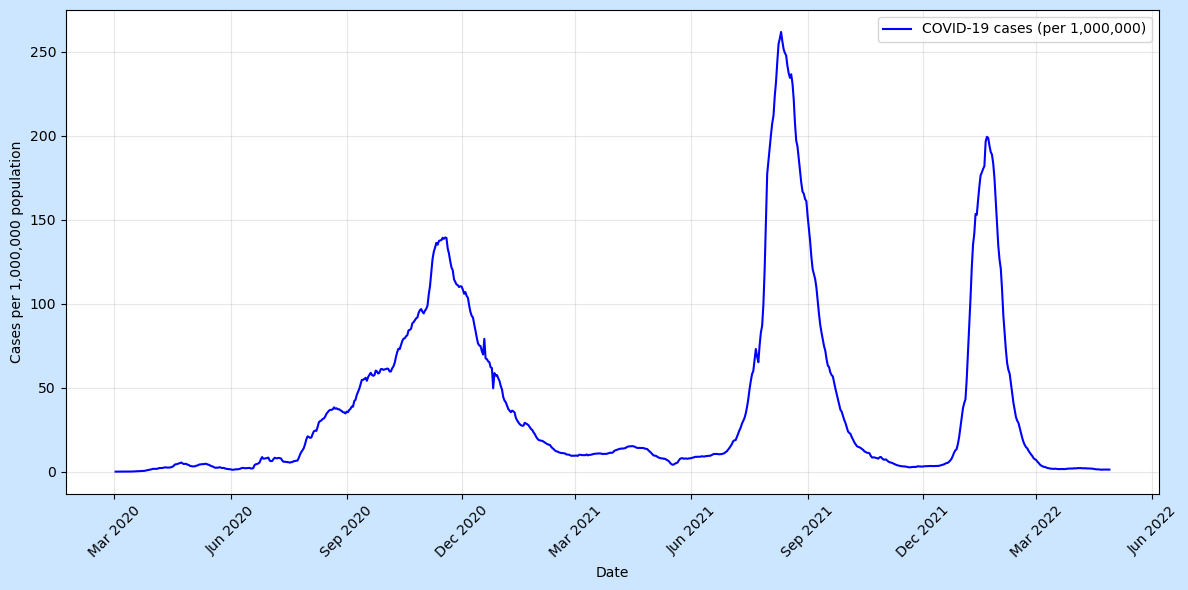

C:\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: overflow encountered in expm1
  result = func(self.values, **kwargs)


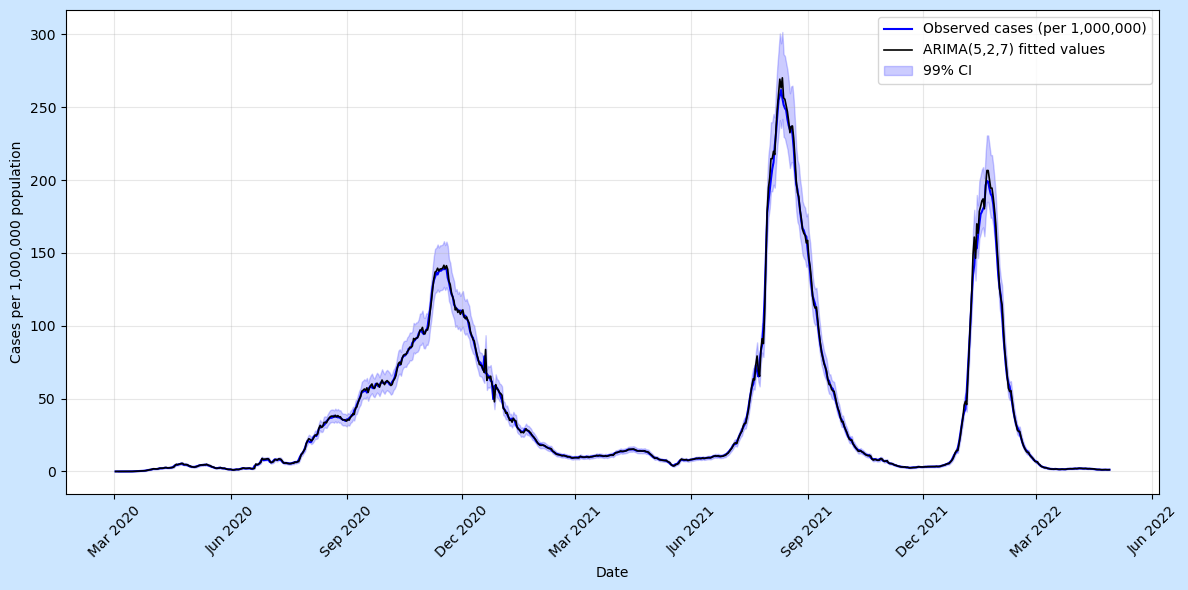

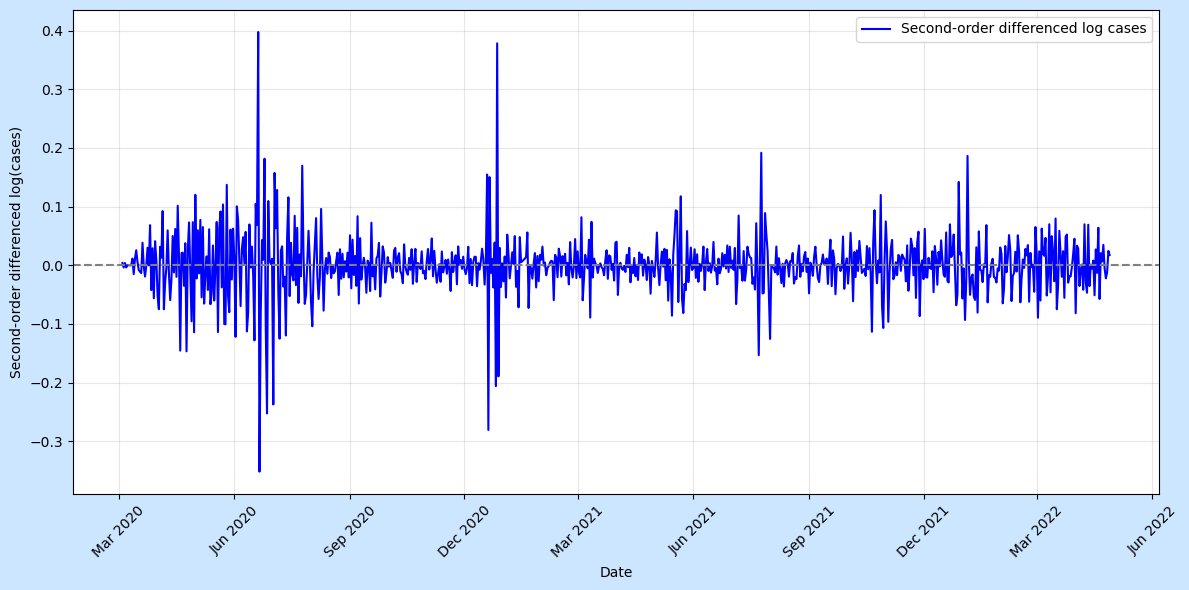

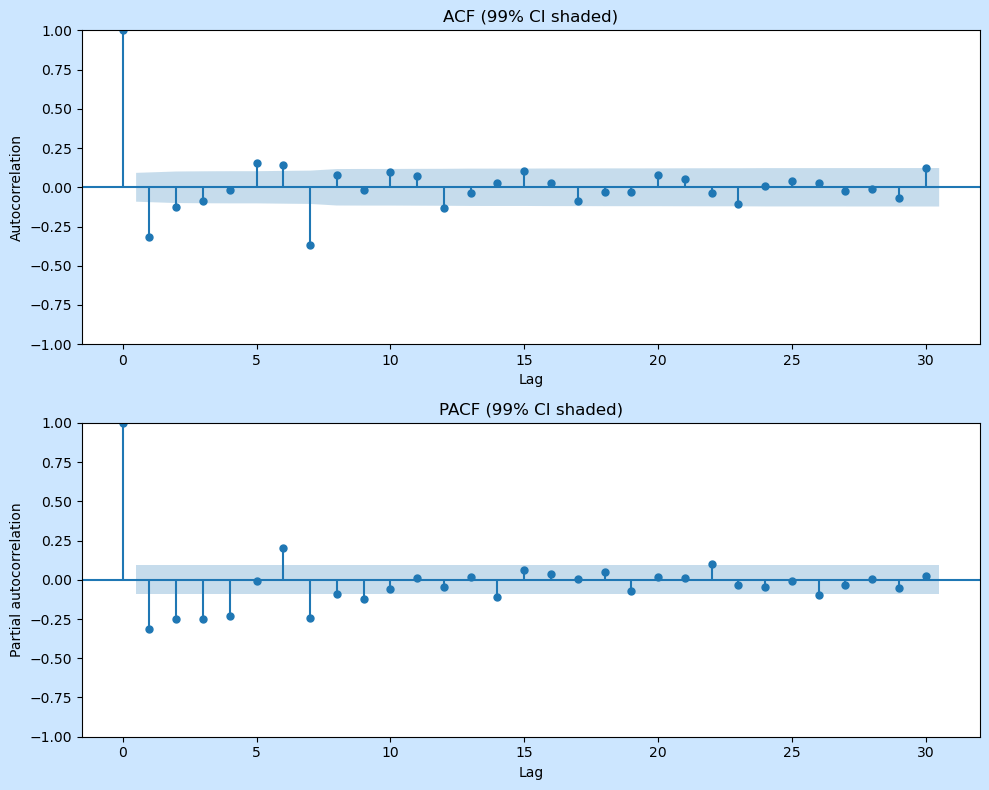

C:\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


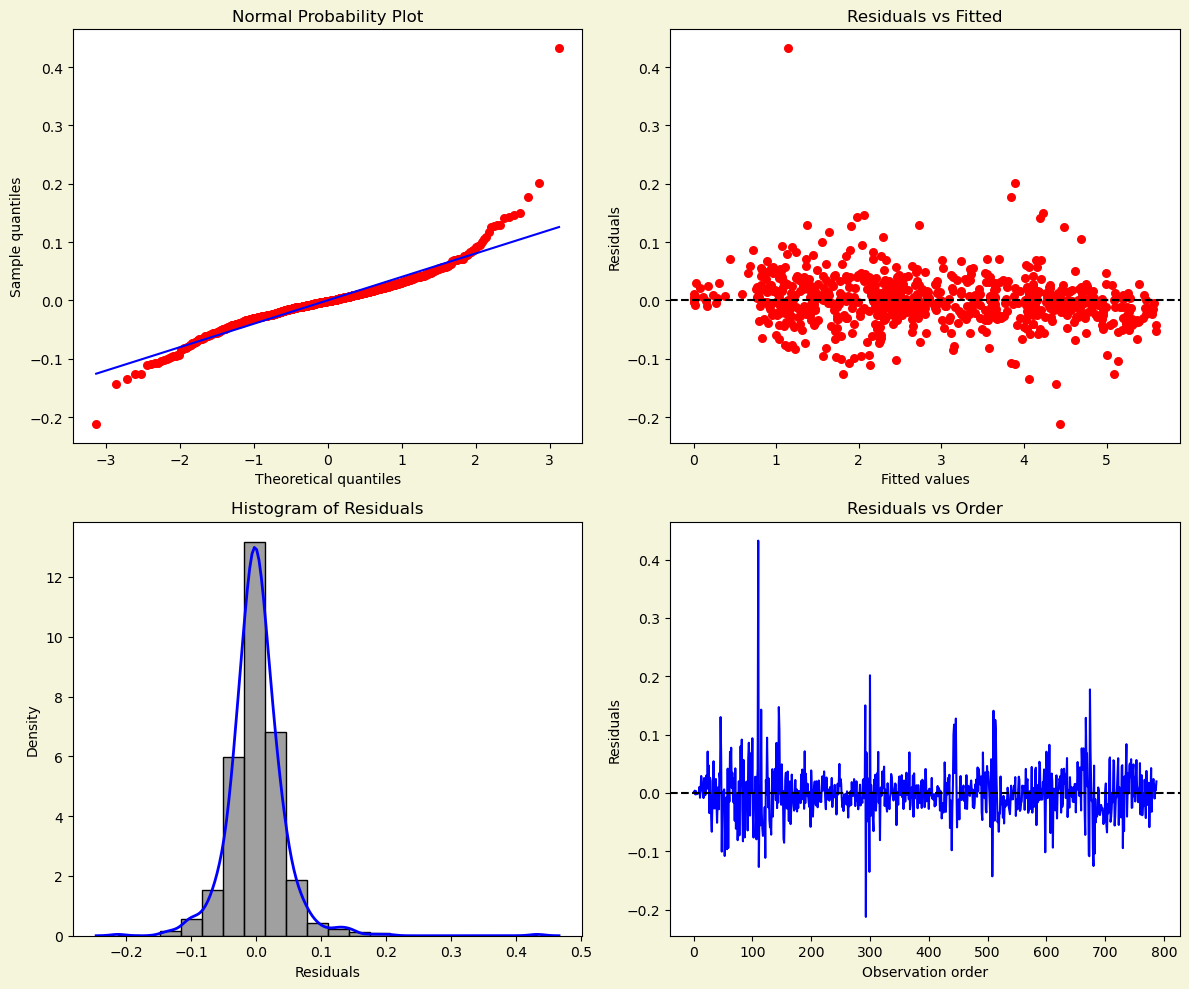

In [1]:
# ==========================================================
# Libraries
# ==========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as stats

# ==========================================================
# Load and prepare Morocco COVID data
# ==========================================================
df = pd.read_excel("Morocco.xlsx", sheet_name="Sheet1")
df.columns = ["Country", "Date", "Cases"]
df["Date"] = pd.to_datetime(df["Date"])

# Filter Morocco + date range
morocco = df[
    (df["Country"] == "Morocco") &
    (df["Date"] >= "2020-03-02") &
    (df["Date"] <= "2022-04-28")
].copy()

# Log transform and second-order differencing
morocco["LogCases"] = np.log1p(morocco["Cases"])
morocco["Diff2_LogCases"] = morocco["LogCases"].diff().diff()
diff_series = morocco.dropna(subset=["Diff2_LogCases"])

# Style variables
outer_bg = "#cce6ff"   # light blue background
inner_bg = "white"     # white plot panels

# ==========================================================
# 1. Original COVID cases (time series)
# ==========================================================
fig, ax = plt.subplots(figsize=(12,6))
fig.patch.set_facecolor(outer_bg)
ax.set_facecolor(inner_bg)

ax.plot(morocco["Date"], morocco["Cases"], color="blue", linewidth=1.5,
        label="COVID-19 cases (per 1,000,000)")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=45)

ax.set_xlabel("Date")
ax.set_ylabel("Cases per 1,000,000 population")
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("cases_timeseries.png", dpi=300, facecolor=fig.get_facecolor())
plt.show()

# ==========================================================
# 2. Time series with ARIMA(5,2,7) fitted values + 99% CI
# ==========================================================
# Fit ARIMA on log scale
model = ARIMA(morocco["LogCases"], order=(5,2,7))
fit = model.fit()

# In-sample predictions and confidence intervals
pred = fit.get_prediction()
pred_mean_log = pred.predicted_mean
pred_ci_log = pred.conf_int(alpha=0.01)  # 99% CI

# Back-transform to original scale
pred_mean = np.expm1(pred_mean_log)
pred_ci = np.expm1(pred_ci_log)

fig, ax = plt.subplots(figsize=(12,6))
fig.patch.set_facecolor(outer_bg)
ax.set_facecolor(inner_bg)

ax.plot(morocco["Date"], morocco["Cases"], color="blue", linewidth=1.5,
        label="Observed cases (per 1,000,000)")
ax.plot(morocco["Date"], pred_mean, color="black", linewidth=1.2,
        label="ARIMA(5,2,7) fitted values")
ax.fill_between(morocco["Date"], pred_ci.iloc[:,0], pred_ci.iloc[:,1],
                color="blue", alpha=0.2, label="99% CI")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=45)

ax.set_xlabel("Date")
ax.set_ylabel("Cases per 1,000,000 population")
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("cases_with_ci.png", dpi=300, facecolor=fig.get_facecolor())
plt.show()

# ==========================================================
# 3. Second-order differenced log-transformed series
# ==========================================================
fig, ax = plt.subplots(figsize=(12,6))
fig.patch.set_facecolor(outer_bg)
ax.set_facecolor(inner_bg)

ax.plot(diff_series["Date"], diff_series["Diff2_LogCases"], color="blue", linewidth=1.5,
        label="Second-order differenced log cases")
ax.axhline(0, color="gray", linestyle="--")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=45)

ax.set_xlabel("Date")
ax.set_ylabel("Second-order differenced log(cases)")
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("second_order_diff.png", dpi=300, facecolor=fig.get_facecolor())
plt.show()

# ==========================================================
# 4. ACF and PACF plots (99% CI, lag=30)
# ==========================================================
fig, axes = plt.subplots(2, 1, figsize=(10,8))
fig.patch.set_facecolor(outer_bg)

for ax in axes:
    ax.set_facecolor(inner_bg)

plot_acf(diff_series["Diff2_LogCases"], lags=30, ax=axes[0], alpha=0.01)  # 99% CI
axes[0].set_ylabel("Autocorrelation")
axes[0].set_xlabel("Lag")
axes[0].set_title("ACF (99% CI shaded)")

plot_pacf(diff_series["Diff2_LogCases"], lags=30, ax=axes[1], alpha=0.01, method="ywm")
axes[1].set_ylabel("Partial autocorrelation")
axes[1].set_xlabel("Lag")
axes[1].set_title("PACF (99% CI shaded)")

plt.tight_layout()
plt.savefig("acf_pacf.png", dpi=300, facecolor=fig.get_facecolor())
plt.show()

# ==========================================================
# 5. Residual diagnostics (2x2 panel)
# ==========================================================
residuals = fit.resid
fitted_vals = fit.fittedvalues

fig, axes = plt.subplots(2, 2, figsize=(12,10))
fig.patch.set_facecolor("#f5f5dc")  # beige outer background

for ax in axes.flatten():
    ax.set_facecolor("white")

# --- Q-Q Plot ---
osm, osr = stats.probplot(residuals, dist="norm")[:2]
theoretical_q = osm[0]
sample_q = osm[1]
axes[0,0].scatter(theoretical_q, sample_q, color="red", s=30)
slope, intercept, *_ = stats.linregress(theoretical_q, sample_q)
axes[0,0].plot(theoretical_q, intercept + slope*theoretical_q, color="blue")
axes[0,0].set_title("Normal Probability Plot")
axes[0,0].set_xlabel("Theoretical quantiles")
axes[0,0].set_ylabel("Sample quantiles")

# --- Residuals vs Fitted ---
axes[0,1].scatter(fitted_vals, residuals, color="red", s=30)
axes[0,1].axhline(0, color="black", linestyle="--")
axes[0,1].set_title("Residuals vs Fitted")
axes[0,1].set_xlabel("Fitted values")
axes[0,1].set_ylabel("Residuals")

# --- Histogram + KDE ---
sns.histplot(residuals, bins=20, color="gray", stat="density", ax=axes[1,0])
sns.kdeplot(residuals, color="blue", ax=axes[1,0], linewidth=2)
axes[1,0].set_title("Histogram of Residuals")
axes[1,0].set_xlabel("Residuals")
axes[1,0].set_ylabel("Density")

# --- Residuals vs Order ---
axes[1,1].plot(range(len(residuals)), residuals, color="blue")
axes[1,1].axhline(0, color="black", linestyle="--")
axes[1,1].set_title("Residuals vs Order")
axes[1,1].set_xlabel("Observation order")
axes[1,1].set_ylabel("Residuals")

plt.tight_layout()
plt.savefig("residual_diagnostics.png", dpi=300, facecolor=fig.get_facecolor())
plt.show()
